# DDPM

## Set global variable

In [2]:
# Path to dataset
DATASET = "dataset/cats/"
# DATASET = "dataset/lfw/"
DATASET_NAME = DATASET.rstrip('/').split('/')[-1]

# Hyperparameter for training
IMG_SIZE = 64
CHANNELS_IMG = 3
BATCH_SIZE = 16

LEARNING_RATE = 1e-4  #0.0001
# LEARNING_RATE = 1e-5  #0.00001
NUM_EPOCHS = 100

## Count and set number of image variable

In [4]:
import os
import glob

def count_image_files(folder_path, extensions=['.jpg', '.jpeg', '.png', '.gif']):
    count = 0
    for extension in extensions:
        search_pattern = os.path.join(folder_path, '*' + extension)
        count += len(glob.glob(search_pattern))
    return count


In [5]:
NUM_IMAGES = count_image_files(DATASET)

print(f"Number of image files in {DATASET}: {NUM_IMAGES}")

Number of image files in dataset/cats/: 15747


## Set agnostic code

In [6]:
import torch

# agnostic code to detect the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load images to tensor and normalize images

In [4]:
import torchvision.transforms as transforms
from PIL import Image

# Get the list of image filenames
image_filenames = os.listdir(DATASET)

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # convert PIL image to tensor and scales data into [0,1] 
    # transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # Scale between [-1, 1] by (input[channel] - mean[channel]) / std[channel]
])

# Create a list to store the transformed images
transformed_images = []

# Iterate over the first num_images filenames and transform the corresponding images
for i, filename in enumerate(image_filenames[:NUM_IMAGES]):
    # Load the image
    img_path = os.path.join(DATASET, filename)
    image = Image.open(img_path)

    # Apply the transformations
    transformed_image = transform(image)

    # Append the transformed image to the list
    transformed_images.append(transformed_image)

# Convert the list of transformed images to a PyTorch tensor
transformed_images = torch.stack(transformed_images)

print(f'Loaded data: {transformed_images.shape}')

Loaded data: torch.Size([12876, 3, 64, 64])


## Separate batch size 

In [5]:
from torch.utils.data import DataLoader

data_loader = DataLoader(transformed_images, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# print first batch.shape
data_iter = iter(data_loader)
print(next(data_iter).shape)

torch.Size([16, 3, 64, 64])


## Train model and save weight and log 

## training process
parameter base on DDPM and unet papers https://arxiv.org/pdf/1505.04597v1.pdf

In [6]:
import time
from modules.ddpm import Diffusion, UNet

import torch.optim as optim
import torch.nn as nn
import torchvision

from torch.utils.tensorboard import SummaryWriter

model = UNet().to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
mse = nn.MSELoss()
diffusion = Diffusion(img_size=IMG_SIZE, device=device)
writer = SummaryWriter(os.path.join(f"logs/{DATASET_NAME}","DDPM"))

l = len(data_loader)

time_use = 0

for epoch in range(NUM_EPOCHS):

    lossMean = 0

    # use time for time measurement
    start_time = time.time()

    model.train()
    
    for batch_idx, images in enumerate(data_loader):
        images = images.to(device)
        t = diffusion.sample_timesteps(images.shape[0]).to(device)
        x_t, noise = diffusion.noise_images(images, t)
        predicted_noise = model(x_t, t)
        loss = mse(noise, predicted_noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # sum lose
        lossMean += loss

        # add log at first 
        if epoch == 0 and batch_idx == 0:
            writer.add_scalar("Loss/MSE", lossMean, global_step=epoch)
            writer.add_scalar("traing time", time_use, epoch)

    end_time = time.time()
    epoch_time = end_time - start_time

    time_use += epoch_time 

    epoch_index = epoch+1

    # calculate mean value
    lossMean = lossMean / len(data_loader.dataset)

    print(
        f"Epoch [{epoch_index}/{NUM_EPOCHS}] Batch {batch_idx+1}/{len(data_loader)} Using Time: {epoch_time:.4f}\
            Loss: {lossMean:.4f}"
    )

    # tensorboard
    writer.add_scalar("Loss/MSE", lossMean, global_step=epoch+1)
    writer.add_scalar("traing time", time_use, epoch_index)

    weight_path = os.path.join("weights", f'{DATASET_NAME}', "DDPM")
    os.makedirs(weight_path, exist_ok=True)
    torch.save(model.state_dict(), os.path.join("weights", f'{DATASET_NAME}', "DDPM", f"{epoch_index}.pt"))

    model.eval()
    with torch.no_grad():
        x = diffusion.sample(model, n=32).type(dtype=torch.float32)
        img_grid = torchvision.utils.make_grid(x[:32], normalize=True)
        writer.add_image("All/Gen", img_grid, global_step=epoch_index)


/home/nice/mambaforge/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/100] Batch 804/804 Using Time: 206.7065            Loss: 0.0072


999it [02:43,  6.10it/s]


Epoch [2/100] Batch 804/804 Using Time: 212.6587            Loss: 0.0025


999it [02:44,  6.07it/s]


Epoch [3/100] Batch 804/804 Using Time: 212.7700            Loss: 0.0021


999it [02:45,  6.04it/s]


Epoch [4/100] Batch 804/804 Using Time: 213.6989            Loss: 0.0018


999it [02:45,  6.02it/s]


Epoch [5/100] Batch 804/804 Using Time: 213.9060            Loss: 0.0017


999it [02:46,  6.00it/s]


Epoch [6/100] Batch 804/804 Using Time: 213.9101            Loss: 0.0016


999it [02:45,  6.02it/s]


Epoch [7/100] Batch 804/804 Using Time: 213.5752            Loss: 0.0014


999it [02:46,  6.00it/s]


Epoch [8/100] Batch 804/804 Using Time: 215.2891            Loss: 0.0015


999it [02:47,  5.96it/s]


Epoch [9/100] Batch 804/804 Using Time: 215.9116            Loss: 0.0013


999it [02:48,  5.94it/s]


Epoch [10/100] Batch 804/804 Using Time: 215.8017            Loss: 0.0013


999it [02:47,  5.96it/s]


Epoch [11/100] Batch 804/804 Using Time: 215.4030            Loss: 0.0013


999it [02:47,  5.96it/s]


Epoch [12/100] Batch 804/804 Using Time: 214.9980            Loss: 0.0012


999it [02:47,  5.95it/s]


Epoch [13/100] Batch 804/804 Using Time: 215.4285            Loss: 0.0012


999it [02:47,  5.97it/s]


Epoch [14/100] Batch 804/804 Using Time: 215.0088            Loss: 0.0012


999it [02:47,  5.97it/s]


Epoch [15/100] Batch 804/804 Using Time: 213.9613            Loss: 0.0012


999it [02:47,  5.98it/s]


Epoch [16/100] Batch 804/804 Using Time: 215.4945            Loss: 0.0012


999it [02:48,  5.94it/s]


Epoch [17/100] Batch 804/804 Using Time: 215.5220            Loss: 0.0012


999it [02:48,  5.94it/s]


Epoch [18/100] Batch 804/804 Using Time: 215.2501            Loss: 0.0012


999it [02:47,  5.95it/s]


Epoch [19/100] Batch 804/804 Using Time: 215.0584            Loss: 0.0011


999it [02:47,  5.96it/s]


Epoch [20/100] Batch 804/804 Using Time: 215.4775            Loss: 0.0011


999it [02:47,  5.96it/s]


Epoch [21/100] Batch 804/804 Using Time: 215.1458            Loss: 0.0011


999it [02:47,  5.96it/s]


Epoch [22/100] Batch 804/804 Using Time: 215.7161            Loss: 0.0011


999it [02:48,  5.93it/s]


Epoch [23/100] Batch 804/804 Using Time: 215.8502            Loss: 0.0011


999it [02:47,  5.96it/s]


Epoch [24/100] Batch 804/804 Using Time: 215.2973            Loss: 0.0011


999it [02:47,  5.97it/s]


Epoch [25/100] Batch 804/804 Using Time: 212.0260            Loss: 0.0011


999it [02:44,  6.06it/s]


Epoch [26/100] Batch 804/804 Using Time: 211.7509            Loss: 0.0010


999it [02:43,  6.09it/s]


Epoch [27/100] Batch 804/804 Using Time: 211.9422            Loss: 0.0011


999it [02:44,  6.07it/s]


Epoch [28/100] Batch 804/804 Using Time: 211.7682            Loss: 0.0010


999it [02:44,  6.06it/s]


Epoch [29/100] Batch 804/804 Using Time: 212.0861            Loss: 0.0011


999it [02:44,  6.07it/s]


Epoch [30/100] Batch 804/804 Using Time: 211.4202            Loss: 0.0010


999it [02:44,  6.07it/s]


Epoch [31/100] Batch 804/804 Using Time: 211.8441            Loss: 0.0010


999it [02:44,  6.06it/s]


Epoch [32/100] Batch 804/804 Using Time: 212.1057            Loss: 0.0010


999it [02:44,  6.05it/s]


Epoch [33/100] Batch 804/804 Using Time: 212.0261            Loss: 0.0011


999it [02:44,  6.09it/s]


Epoch [34/100] Batch 804/804 Using Time: 211.9107            Loss: 0.0010


999it [02:44,  6.08it/s]


Epoch [35/100] Batch 804/804 Using Time: 210.9532            Loss: 0.0010


999it [02:43,  6.12it/s]


Epoch [36/100] Batch 804/804 Using Time: 210.6350            Loss: 0.0010


999it [02:44,  6.09it/s]


Epoch [37/100] Batch 804/804 Using Time: 211.5892            Loss: 0.0010


999it [02:44,  6.07it/s]


Epoch [38/100] Batch 804/804 Using Time: 211.1664            Loss: 0.0010


999it [02:43,  6.10it/s]


Epoch [39/100] Batch 804/804 Using Time: 210.8496            Loss: 0.0010


999it [02:43,  6.10it/s]


Epoch [40/100] Batch 804/804 Using Time: 211.2310            Loss: 0.0010


999it [02:43,  6.10it/s]


Epoch [41/100] Batch 804/804 Using Time: 210.9908            Loss: 0.0010


999it [02:44,  6.09it/s]


Epoch [42/100] Batch 804/804 Using Time: 210.8354            Loss: 0.0010


999it [02:43,  6.10it/s]


Epoch [43/100] Batch 804/804 Using Time: 210.7328            Loss: 0.0010


999it [02:43,  6.12it/s]


Epoch [44/100] Batch 804/804 Using Time: 210.1425            Loss: 0.0010


999it [02:43,  6.10it/s]


Epoch [45/100] Batch 804/804 Using Time: 210.3559            Loss: 0.0010


999it [02:43,  6.11it/s]


Epoch [46/100] Batch 804/804 Using Time: 210.2317            Loss: 0.0010


999it [02:43,  6.12it/s]


Epoch [47/100] Batch 804/804 Using Time: 210.3400            Loss: 0.0010


999it [02:43,  6.13it/s]


Epoch [48/100] Batch 804/804 Using Time: 209.8910            Loss: 0.0010


999it [02:43,  6.12it/s]


Epoch [49/100] Batch 804/804 Using Time: 210.3391            Loss: 0.0010


999it [02:43,  6.11it/s]


Epoch [50/100] Batch 804/804 Using Time: 210.4483            Loss: 0.0010


999it [02:42,  6.13it/s]


Epoch [51/100] Batch 804/804 Using Time: 210.2085            Loss: 0.0010


999it [02:42,  6.14it/s]


Epoch [52/100] Batch 804/804 Using Time: 209.7093            Loss: 0.0010


999it [02:42,  6.16it/s]


Epoch [53/100] Batch 804/804 Using Time: 209.2183            Loss: 0.0010


999it [02:42,  6.14it/s]


Epoch [54/100] Batch 804/804 Using Time: 210.6819            Loss: 0.0010


999it [02:43,  6.12it/s]


Epoch [55/100] Batch 804/804 Using Time: 210.0818            Loss: 0.0010


999it [02:43,  6.12it/s]


Epoch [56/100] Batch 804/804 Using Time: 210.1974            Loss: 0.0010


999it [02:42,  6.13it/s]


Epoch [57/100] Batch 804/804 Using Time: 210.1996            Loss: 0.0010


999it [02:43,  6.13it/s]


Epoch [58/100] Batch 804/804 Using Time: 210.0766            Loss: 0.0010


999it [02:42,  6.13it/s]


Epoch [59/100] Batch 804/804 Using Time: 210.2894            Loss: 0.0009


999it [02:42,  6.13it/s]


Epoch [60/100] Batch 804/804 Using Time: 210.3866            Loss: 0.0009


999it [02:42,  6.13it/s]


Epoch [61/100] Batch 804/804 Using Time: 209.5156            Loss: 0.0010


999it [02:42,  6.16it/s]


Epoch [62/100] Batch 804/804 Using Time: 209.4802            Loss: 0.0010


999it [02:41,  6.17it/s]


Epoch [63/100] Batch 804/804 Using Time: 209.1459            Loss: 0.0010


999it [02:42,  6.16it/s]


Epoch [64/100] Batch 804/804 Using Time: 209.2562            Loss: 0.0010


999it [02:41,  6.17it/s]


Epoch [65/100] Batch 804/804 Using Time: 209.2849            Loss: 0.0010


999it [02:42,  6.16it/s]


Epoch [66/100] Batch 804/804 Using Time: 208.8800            Loss: 0.0010


999it [02:42,  6.16it/s]


Epoch [67/100] Batch 804/804 Using Time: 209.6304            Loss: 0.0009


999it [02:42,  6.15it/s]


Epoch [68/100] Batch 804/804 Using Time: 209.5612            Loss: 0.0009


999it [02:41,  6.18it/s]


Epoch [69/100] Batch 804/804 Using Time: 208.6042            Loss: 0.0009


999it [02:41,  6.17it/s]


Epoch [70/100] Batch 804/804 Using Time: 209.0393            Loss: 0.0010


999it [02:42,  6.16it/s]


Epoch [71/100] Batch 804/804 Using Time: 209.2235            Loss: 0.0009


999it [02:42,  6.17it/s]


Epoch [72/100] Batch 804/804 Using Time: 208.7986            Loss: 0.0009


999it [02:41,  6.17it/s]


Epoch [73/100] Batch 804/804 Using Time: 208.7386            Loss: 0.0010


999it [02:41,  6.17it/s]


Epoch [74/100] Batch 804/804 Using Time: 209.0527            Loss: 0.0009


999it [02:41,  6.18it/s]


Epoch [75/100] Batch 804/804 Using Time: 208.8446            Loss: 0.0009


999it [02:41,  6.17it/s]


Epoch [76/100] Batch 804/804 Using Time: 209.3455            Loss: 0.0009


999it [02:42,  6.16it/s]


Epoch [77/100] Batch 804/804 Using Time: 209.7231            Loss: 0.0010


999it [02:49,  5.88it/s]


Epoch [78/100] Batch 804/804 Using Time: 215.8785            Loss: 0.0009


999it [02:47,  5.97it/s]


Epoch [79/100] Batch 804/804 Using Time: 210.9632            Loss: 0.0009


999it [02:42,  6.14it/s]


Epoch [80/100] Batch 804/804 Using Time: 210.9089            Loss: 0.0009


999it [02:44,  6.06it/s]


Epoch [81/100] Batch 804/804 Using Time: 213.3553            Loss: 0.0009


999it [02:44,  6.09it/s]


Epoch [82/100] Batch 804/804 Using Time: 211.9788            Loss: 0.0009


999it [02:43,  6.09it/s]


Epoch [83/100] Batch 804/804 Using Time: 210.7370            Loss: 0.0010


999it [02:44,  6.07it/s]


Epoch [84/100] Batch 804/804 Using Time: 211.4698            Loss: 0.0009


999it [02:43,  6.11it/s]


Epoch [85/100] Batch 804/804 Using Time: 210.7267            Loss: 0.0009


999it [02:43,  6.10it/s]


Epoch [86/100] Batch 804/804 Using Time: 212.2509            Loss: 0.0009


999it [02:45,  6.04it/s]


Epoch [87/100] Batch 804/804 Using Time: 212.4837            Loss: 0.0009


999it [02:44,  6.09it/s]


Epoch [88/100] Batch 804/804 Using Time: 213.4489            Loss: 0.0009


999it [02:44,  6.07it/s]


Epoch [89/100] Batch 804/804 Using Time: 214.5439            Loss: 0.0009


999it [02:44,  6.08it/s]


Epoch [90/100] Batch 804/804 Using Time: 212.4186            Loss: 0.0009


999it [02:43,  6.10it/s]


Epoch [91/100] Batch 804/804 Using Time: 210.3076            Loss: 0.0009


999it [02:44,  6.07it/s]


Epoch [92/100] Batch 804/804 Using Time: 211.7946            Loss: 0.0009


999it [02:44,  6.07it/s]


Epoch [93/100] Batch 804/804 Using Time: 212.7197            Loss: 0.0009


999it [02:44,  6.06it/s]


Epoch [94/100] Batch 804/804 Using Time: 213.1965            Loss: 0.0009


999it [02:49,  5.88it/s]


Epoch [95/100] Batch 804/804 Using Time: 213.8210            Loss: 0.0009


999it [02:46,  5.99it/s]


Epoch [96/100] Batch 804/804 Using Time: 214.5201            Loss: 0.0009


999it [02:46,  5.98it/s]


Epoch [97/100] Batch 804/804 Using Time: 214.5922            Loss: 0.0009


999it [02:46,  6.00it/s]


Epoch [98/100] Batch 804/804 Using Time: 212.8345            Loss: 0.0009


999it [02:45,  6.03it/s]


Epoch [99/100] Batch 804/804 Using Time: 213.2356            Loss: 0.0009


999it [02:44,  6.07it/s]


Epoch [100/100] Batch 804/804 Using Time: 211.6610            Loss: 0.0009


999it [02:44,  6.08it/s]


# change image when sample

In [8]:
x = diffusion.sample(model, n=32).type(dtype=torch.float32)
img_grid = torchvision.utils.make_grid(x[:32], normalize=True)

999it [02:39,  6.25it/s]


999it [00:16, 62.20it/s]


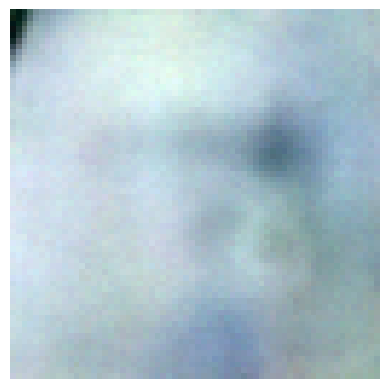

In [25]:
import matplotlib.pyplot as plt
from modules.ddpm import Diffusion, UNet
import torchvision

diffusion = Diffusion(img_size=IMG_SIZE, device=device)
model = UNet().to(device=device)

for i in range(1): 

    index = 100
    
    model.load_state_dict(torch.load(f'weights/lfw/DDPM/{index}.pt'))
    x = diffusion.sample(model, n=1).type(dtype=torch.float32)
    img_grid = torchvision.utils.make_grid(x[:32], normalize=True)
    
    # Convert the image tensor to a numpy array
    np_img = img_grid.cpu().numpy().transpose((1, 2, 0))

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Display the image grid
    ax.imshow(np_img)

    # Remove ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()



# Measure FID

use this implementation: https://github.com/mseitzer/pytorch-fid/tree/master

## define FID measurement function 

In [7]:
import subprocess
import torch
from torchvision.utils import save_image
import re
import os
import gc
from modules.ddpm import  Diffusion


# Create a function to run the FID script
def run_fid(real_path, gen_path):
    command = ["python", "-m", "pytorch_fid", real_path, gen_path]

    output = subprocess.run(command, capture_output=True, text=True)

    # Extract the FID score using regular expressions
    output = output.stdout

    fid_score_match = re.search(r"FID:\s+(-?\d+\.\d+)", output)
    
    if fid_score_match:
        fid_score = float(fid_score_match.group(1))
        
        return fid_score

    else:
        print("FID score not found in the output.")

def generate_images(model, sample_size=100*8, batch_size=8, device="cuda", real_path=f"dataset/{DATASET_NAME}/", gen_path=f"generated_images/{DATASET_NAME}/DCGAN"):

    diffusion = Diffusion(img_size=IMG_SIZE, device=device)
    
    # Set the model to evaluation mode
    model.eval()

    # Create a folder for generated images if it doesn't exist
    os.makedirs(gen_path, exist_ok=True)

    # Generate images
    with torch.no_grad():
        for i in range(0, sample_size, batch_size):
            
            x = diffusion.sample(model, n=batch_size).type(dtype=torch.float32)

            for j in range(batch_size):
                save_image(x[j], f"{gen_path}/{i+j}.png", normalize=True)
        
    # model = None
    # gc.collect() 

    with torch.no_grad():
        del model
        torch.cuda.empty_cache()



## Load weight of model to measure FID score

In [8]:
def load_weight( model, weight_path="", index=int):
    # Load the saved weights
    model.load_state_dict(torch.load(f'{weight_path}/{index}.pt'))
    

In [9]:
from modules.ddpm import UNet
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(f'logs/{DATASET_NAME}/DDPM/')

# Specify the directory path
directory_path = Path(f'weights/{DATASET_NAME}/DDPM/')

# Get the list of files ending with ".pth"
# file_list = list(directory_path.glob('*.pt'))

sample_size = 5000

start = 1
stop = NUM_EPOCHS+1
step = 7

for i in range(start, stop, step):

    index_weight = i

    # model = UNet().to(device)

    # load_weight(model, weight_path=directory_path, index=index_weight)

    # generate_images(model, sample_size, batch_size=64, device=f'{device}', gen_path=f'gen/{DATASET_NAME}/DDPM/{index_weight}')

    # FID measurement
    fid_score = run_fid(f"{DATASET}", f"gen/{DATASET_NAME}/DCGAN/{index_weight}")
    print(f'Epoch: {index_weight} FID score: {fid_score}')
    writer.add_scalar("Metrics/FID Score", fid_score, index_weight)


# subprocess

In [ ]:
import subprocess

index = 1
# Define the command to be executed
command = [
    "python",
    "modules/ddpm_sample.py",
    "--sample-size",
    "900",
    "--batch-size",
    "50",
    "--gen-path",
    f"gen/{DATASET_NAME}/DDPM/{index}",
    "--weight-path",    
    f"weights/{DATASET_NAME}/DDPM/{index}.pt"
]

# Run the command and capture the output
try:
    output = subprocess.check_output(command)
    output = output.decode("utf-8")  # Decode the byte output to string (if needed)
    print(output)
except subprocess.CalledProcessError as e:
    print("Command execution failed:", e)


In [6]:
import subprocess

start = 1
stop = 100
step = 7

epochs = range(start,stop,step)
# print(len(epochs))
samples_n = 5000

for index in epochs:
    gen_n = count_image_files(f"gen/{DATASET_NAME}/DDPM/{index}")

    if gen_n < samples_n:
        remain = samples_n - gen_n
        print("Epoch:",index,"Remaining",remain,"images to generate")

        command = [
            "python",
            "modules/ddpm_sample.py",
            "--sample-size",
            f"{remain}",
            "--batch-size",
            "50",
            "--gen-path",
            f"gen/{DATASET_NAME}/DDPM/{index}",
            "--weight-path",
            f"weights/{DATASET_NAME}/DDPM/{index}.pt"
        ]

        try:
            output = subprocess.check_output(command)
            output = output.decode("utf-8")  # Decode the byte output to string (if needed)
            print(output)
        except subprocess.CalledProcessError as e:
            print("Command execution failed:", e)
        
    else:
        print("Epoch:",index,"Done")

Epoch: 1 Done
Epoch: 8 Done
Epoch: 15 Done
Epoch: 22 Done
Epoch: 29 Done
Epoch: 36 Done
Epoch: 43 Done
Epoch: 50 Done
Epoch: 57 Done
Epoch: 64 Done
Epoch: 71 Done
Epoch: 78 Remaining 1450 images to generate


0it [00:00, ?it/s]/home/nice/mambaforge/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
999it [05:13,  3.18it/s]
999it [05:07,  3.25it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.23it/s]
999it [05:09,  3.23it/s]
999it [05:08,  3.23it/s]
999it [05:08,  3.24it/s]
999it [05:09,  3.23it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3

subprocess done.

Epoch: 85 Remaining 5000 images to generate


0it [00:00, ?it/s]/home/nice/mambaforge/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.23it/s]
999it [05:09,  3.23it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.23it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.23it/s]
999it [05:09,  3.23it/s]
999it [05:09,  3.23it/s]
999it [05:08,  3.23it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3.24it/s]
999it [05:08,  3

subprocess done.

Epoch: 92 Remaining 5000 images to generate


0it [00:00, ?it/s]/home/nice/mambaforge/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
999it [05:14,  3.17it/s]
999it [05:14,  3.18it/s]
999it [05:12,  3.19it/s]
999it [05:13,  3.19it/s]
999it [05:14,  3.18it/s]
999it [05:14,  3.18it/s]
999it [05:14,  3.18it/s]
999it [05:14,  3.18it/s]
999it [05:14,  3.17it/s]
999it [05:14,  3.17it/s]
999it [05:12,  3.19it/s]
999it [05:15,  3.17it/s]
999it [05:14,  3.17it/s]
999it [05:16,  3.16it/s]
999it [05:16,  3.16it/s]
999it [05:16,  3.16it/s]
999it [05:13,  3.19it/s]
999it [05:12,  3.20it/s]
999it [05:10,  3.22it/s]
999it [05:12,  3.20it/s]
999it [05:14,  3.18it/s]
999it [05:13,  3.19it/s]
999it [05:13,  3.19it/s]
999it [05:12,  3.20it/s]
999it [05:11,  3.21it/s]
999it [05:11,  3.20it/s]
999it [05:11,  3

subprocess done.

Epoch: 99 Remaining 656 images to generate


0it [00:00, ?it/s]/home/nice/mambaforge/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
999it [05:12,  3.20it/s]
999it [05:10,  3.22it/s]
999it [05:11,  3.20it/s]
999it [05:11,  3.21it/s]
999it [05:12,  3.20it/s]
999it [05:10,  3.22it/s]
999it [05:10,  3.21it/s]
999it [05:10,  3.22it/s]
999it [05:11,  3.21it/s]
999it [05:12,  3.20it/s]
999it [05:10,  3.22it/s]
999it [05:11,  3.21it/s]
999it [05:12,  3.20it/s]
999it [05:10,  3.22it/s]


subprocess done.



# Count learnable parameter in model

In [3]:
model = UNet().to("cuda")


pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
print(pytorch_total_params)

22291587
